In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.qmc import Halton
from scipy.special import rel_entr
from scipy.special import erf
from scipy.optimize import root
from scipy.special import gamma
from scipy.special import gammaincc

In [2]:
def ndim_norm_percentile(n,sigmaRatio):
    # n - integer number of dimensions
    # sigmaRatio - how many sigmas you want to truncate out to
    if n == 1:
        return .5*(erf(sigmaRatio/np.sqrt(2)) - erf(-sigmaRatio/np.sqrt(2)))
    elif n > 1:
        return 1-(gammaincc(n/2,(1/2)*(sigmaRatio)**2))
    

In [3]:
def norm_percentile(sigma_range):
    return .5*(erf(np.max(sigma_range)/np.sqrt(2)) - erf(np.min(sigma_range)/np.sqrt(2)))

In [4]:
class HaltonSampler:
    def __init__(self, d = 3, randomize = False):
        self.d = d
        self.sampler = Halton(self.d, scramble = randomize)
        
    def reset(self):
        self.sampler.reset()
        
    def sample(self, num):
        return 2*self.sampler.random(num+1)[1:]-1
    
class randomSampler:
    def __init__(self, d = 3, randomize = True):
        self.d = d
    
    def reset(self):
        pass
        
    def sample(self, num):
        return 2*np.random.rand(num,self.d)-1
    
class qmcSampler:
    def __init__(self, method='Halton', d = 3, randomize = False):
        self.method = method
        self.d = d
        
        if (self.method == 'Halton' or self.method == 'halton'):
            self.method = 'Halton'
            self.sampler = HaltonSampler(self.d, randomize)
        elif self.method == 'random':
            self.sampler = randomSampler(self.d)
    
    def sampleUniform(self, n_samples, resetSampler = True):
        samples_uniform = self.sampler.sample(n_samples)
        
        if resetSampler == True:
            self.sampler.reset()
            
        return samples_uniform
    
    def sampleGaussian(self, n_samples, truncate = False, truncScale = None):
        if truncate == True:
            # implicitly assumes sigma = 1 at this point, since we haven't scaled anything yet
            n_samples_eff = int(1.25*n_samples/ndim_norm_percentile(n=self.d,sigmaRatio=truncScale))
            
            if n_samples/n_samples_eff<.5:
                print('Efficiency: '+str(np.round(100*n_samples/n_samples_eff,2))+'%')
                
        else:
            n_samples_eff = n_samples
            
        samples_uniform = self.sampleUniform(n_samples_eff)
        samples_gaussian = np.zeros((n_samples_eff,self.d))
        
        for i in range(n_samples_eff):
            for j in range(self.d):
                samples_gaussian[i,j] = np.sqrt(2)*root(
                    fun = lambda x: erf(x)-samples_uniform[i][j],
                    x0 = 0
                ).x
        
        if truncate == True:
            return samples_gaussian[
                np.linalg.norm(samples_gaussian,axis=1)<truncScale
            ][:n_samples]
        
        else:
            return samples_gaussian

# 1D

In [5]:
qmcGS = qmcSampler(d=1,method='Halton')
randGS = qmcSampler(d=1,method='random')

(array([0.0000e+00, 2.0000e+00, 1.7000e+01, 9.7000e+01, 4.9100e+02,
        1.7190e+03, 4.3200e+03, 9.0480e+03, 1.4946e+04, 1.9106e+04,
        1.9192e+04, 1.5087e+04, 9.1580e+03, 4.5420e+03, 1.6500e+03,
        4.8800e+02, 1.1300e+02, 2.1000e+01, 3.0000e+00, 0.0000e+00]),
 array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
         0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <BarContainer object of 20 artists>)

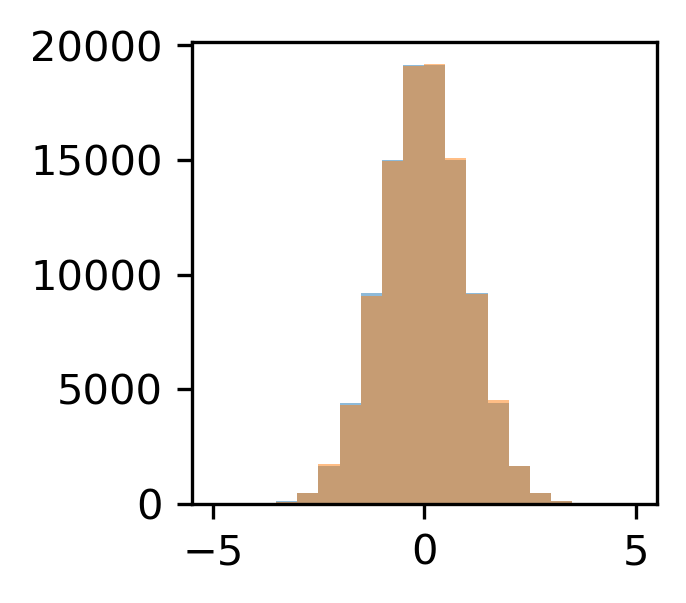

In [6]:
# demonstrate gaussian sampling

plt.figure(figsize=(2,2),dpi=300)
nsamples = 100000
plt.hist(qmcGS.sampleGaussian(nsamples),bins=np.linspace(-5,5,21),alpha=.5)
plt.hist(randGS.sampleGaussian(nsamples),bins=np.linspace(-5,5,21),alpha=.5)

# 2D

In [7]:
qmcGS = qmcSampler(d=2,method='Halton')
randGS = qmcSampler(d=2,method='random')

(-1.0, 1.0)

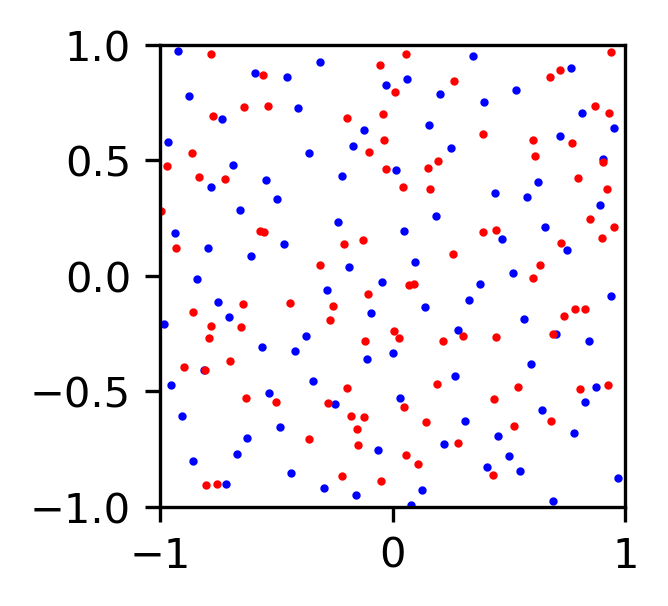

In [8]:
# demonstrate uniform sampling

plt.figure(figsize=(2,2),dpi=300)
nsamples = 100
plt.scatter(qmcGS.sampleUniform(nsamples)[:,0],qmcGS.sampleUniform(nsamples)[:,1],c='b',s=1)
plt.scatter(randGS.sampleUniform(nsamples)[:,0],randGS.sampleUniform(nsamples)[:,1],c='r',s=1)
plt.xlim((-1,1))
plt.ylim((-1,1))

Text(0.5, 1.0, 'Random')

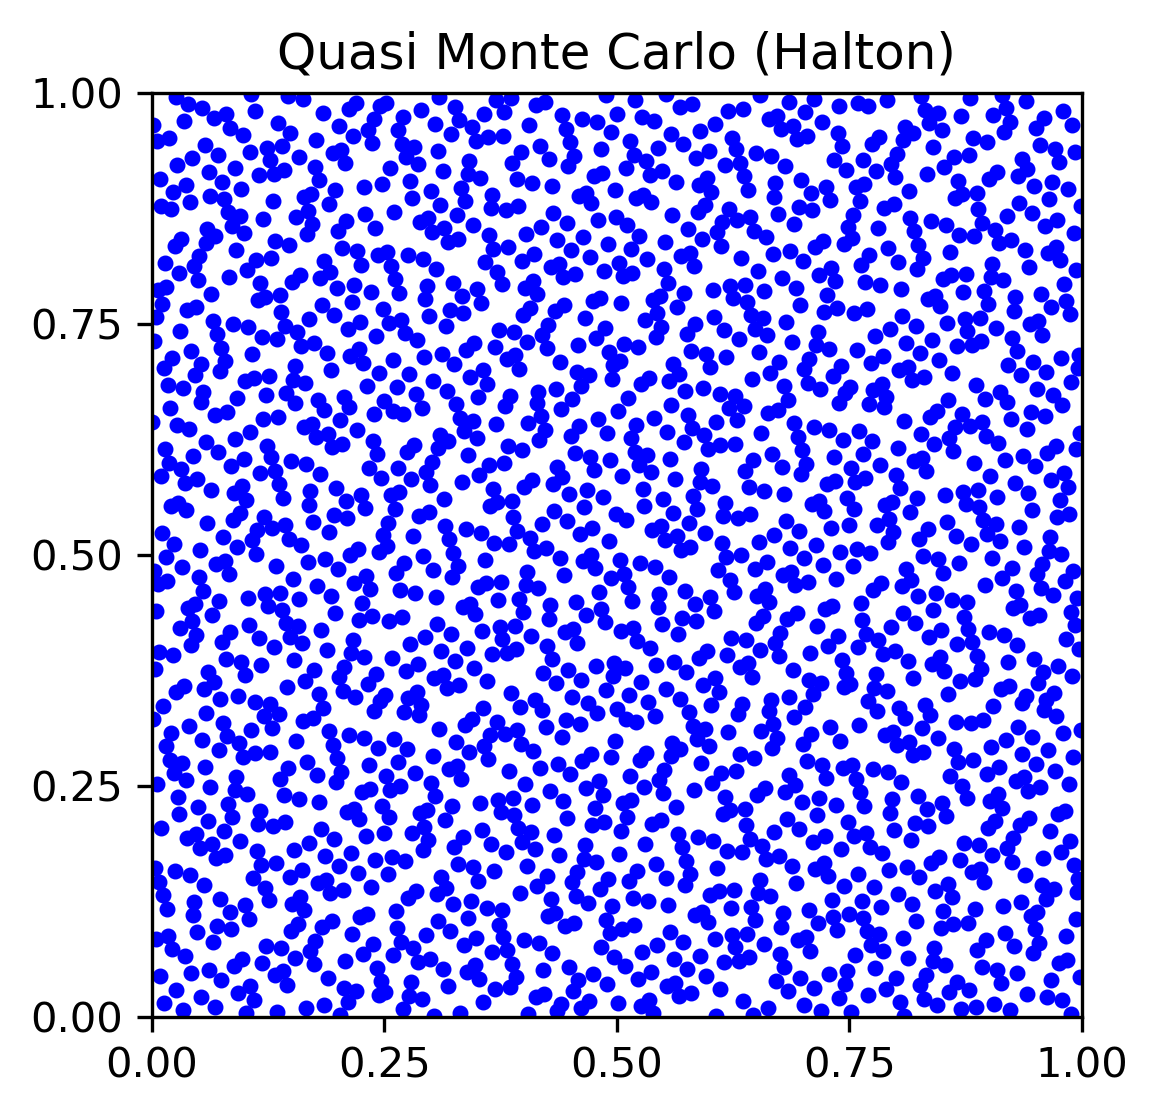

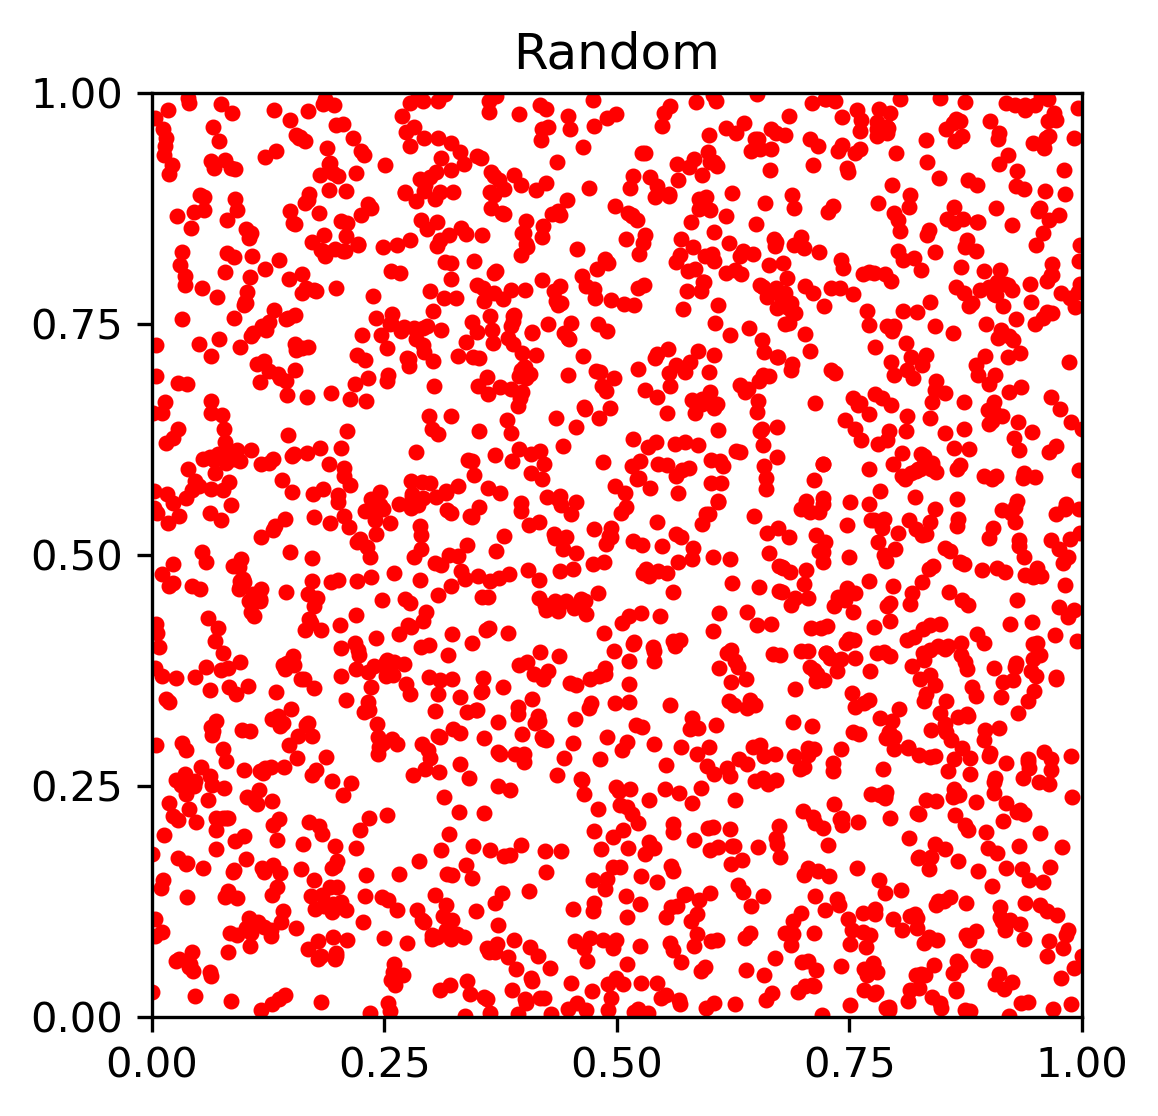

In [28]:
# demonstrate uniform sampling
nsamples = 2000

plt.figure(figsize=(4,4),dpi=300)
plt.scatter(
    .5*(qmcGS.sampleUniform(nsamples)[:,0]+1),
    .5*(qmcGS.sampleUniform(nsamples)[:,1]+1),
    c='b',
    s=8
)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xticks(np.linspace(0,1,5))
plt.yticks(np.linspace(0,1,5))
plt.title('Quasi Monte Carlo (Halton)')

plt.figure(figsize=(4,4),dpi=300)
plt.scatter(
    .5*(randGS.sampleUniform(nsamples)[:,0]+1),
    .5*(randGS.sampleUniform(nsamples)[:,1]+1),
    c='r',
    s=8
)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xticks(np.linspace(0,1,5))
plt.yticks(np.linspace(0,1,5))
plt.title('Random')


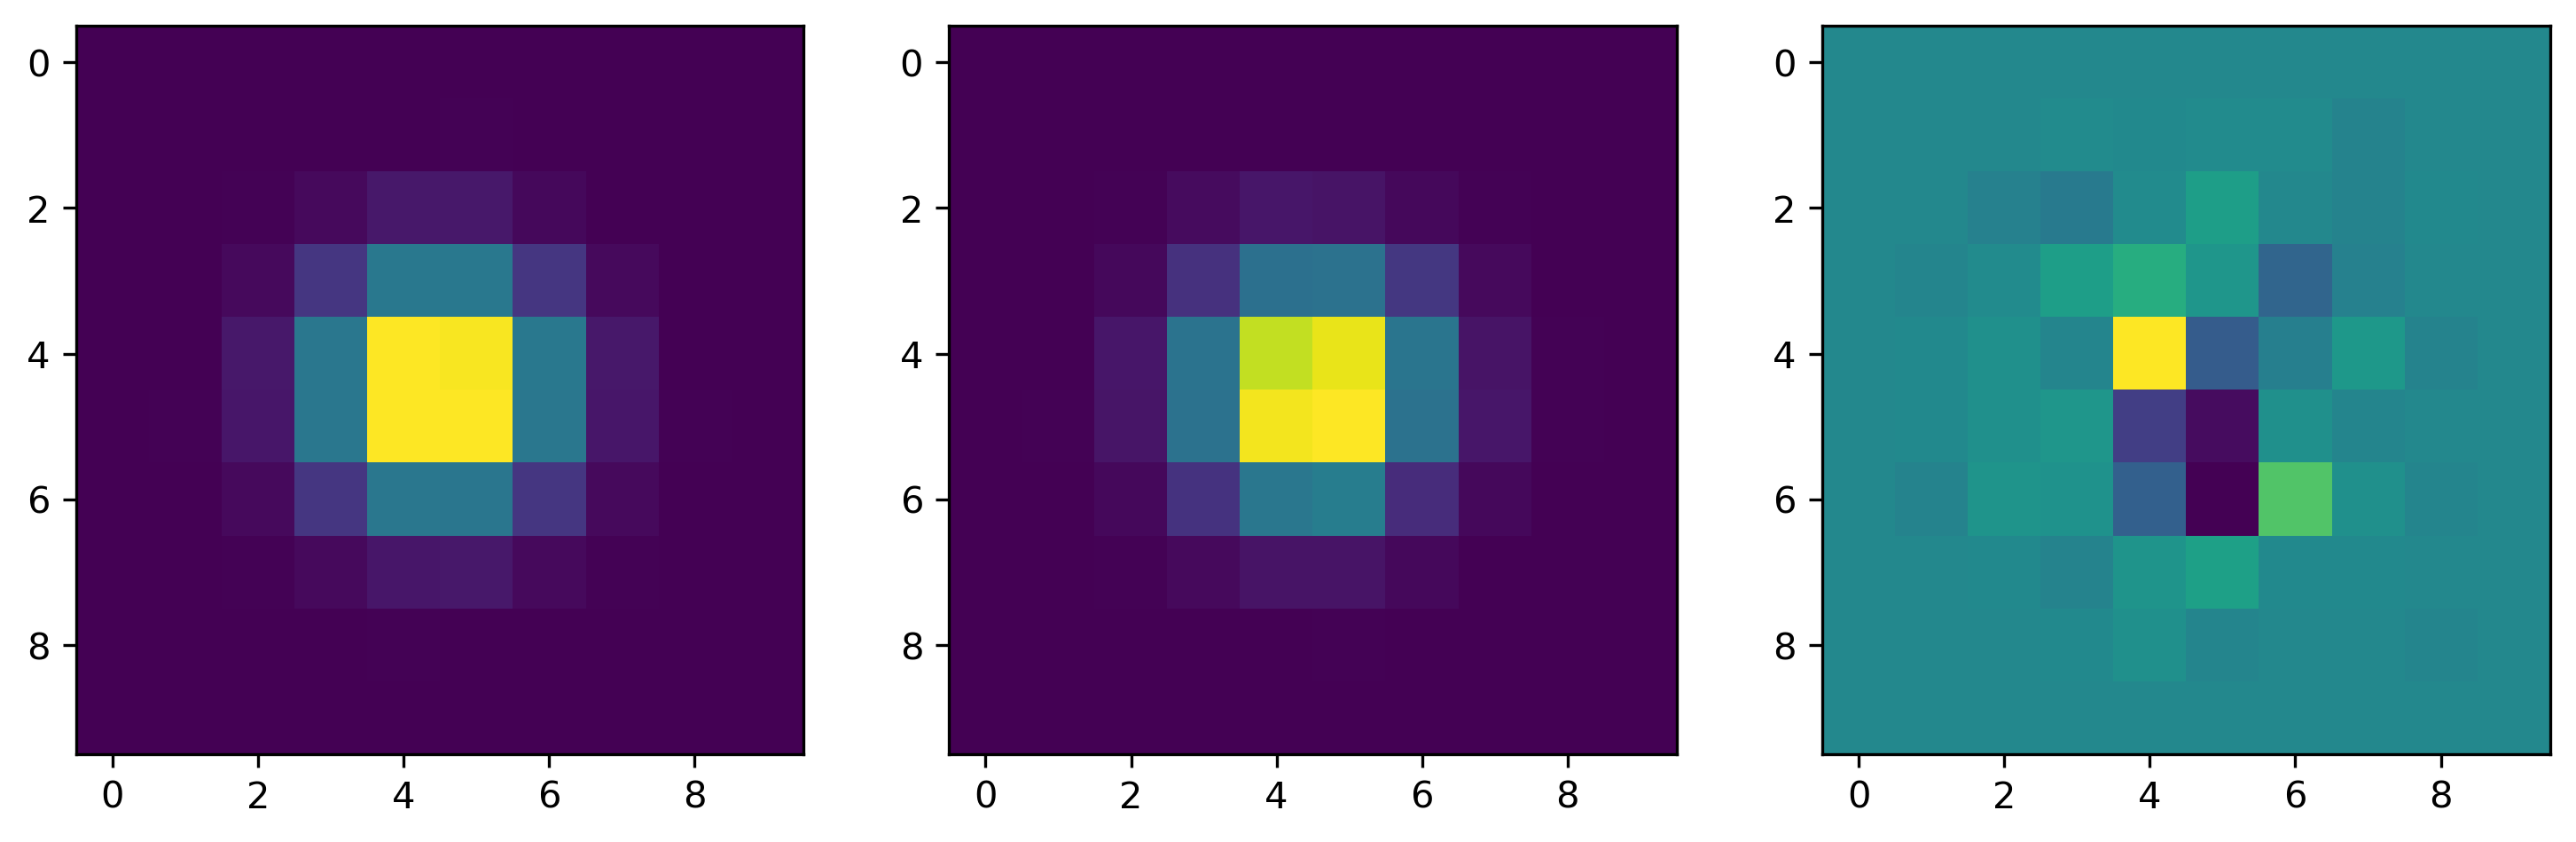

In [15]:
# demonstrate gaussian sampling

fig,ax = plt.subplots(1,3,figsize=(12,4),dpi=300)
nsamples=10000
normPoints = np.random.normal(size=(nsamples,3))

qmcPoints = qmcGS.sampleGaussian(nsamples)
randPoints = randGS.sampleGaussian(nsamples)

qmcHist,_ = np.histogramdd(
    (qmcPoints[:,0],qmcPoints[:,1]),
    bins=(np.linspace(-5,5,11),np.linspace(-5,5,11))
)
normHist,_ = np.histogramdd(
    (randPoints[:,0],randPoints[:,1]),
    bins=(np.linspace(-5,5,11),np.linspace(-5,5,11))
)

ax[0].imshow(qmcHist)
ax[1].imshow(normHist)
ax[2].imshow(qmcHist-normHist)

# 3D

In [16]:
qmcGS = qmcSampler(d=3,method='Halton')
randGS = qmcSampler(d=3,method='random')

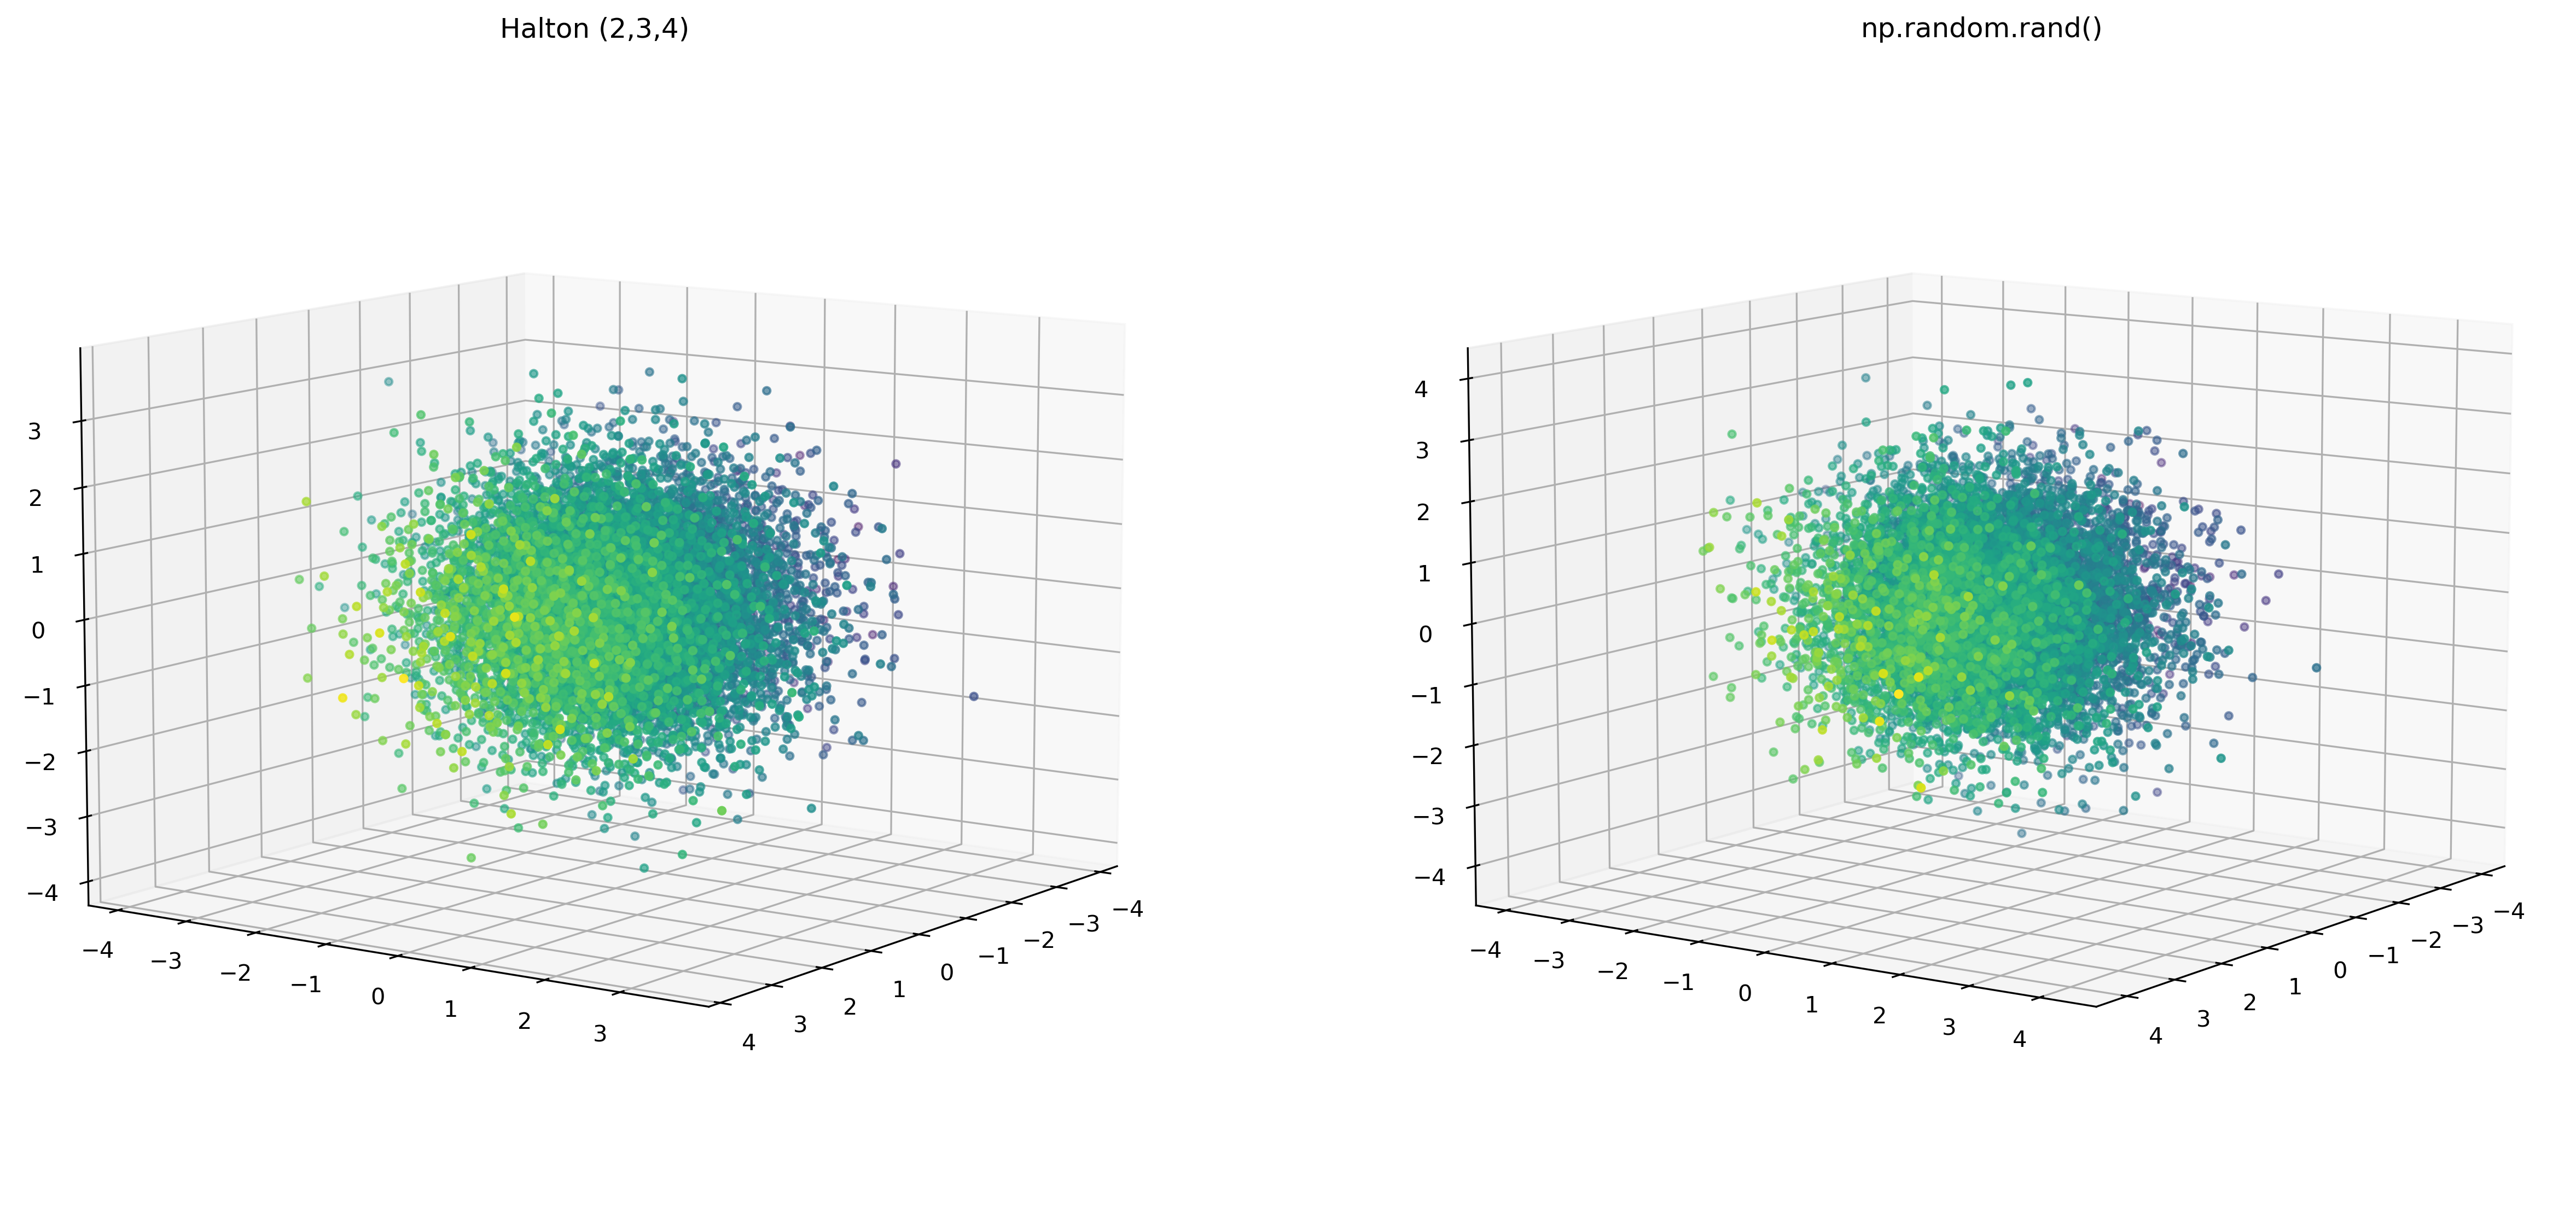

In [17]:
%matplotlib inline
point_size = 10

fig = plt.figure(figsize=(20,10),dpi=300)
nsamples=10000
qmcPoints = qmcGS.sampleGaussian(nsamples)
randPoints = randGS.sampleGaussian(nsamples)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.view_init(10, 35)
ax.scatter3D(
    qmcPoints[:,0], qmcPoints[:,1], qmcPoints[:,2],
    c=qmcPoints[:,0], cmap='viridis',
    s=point_size
)
ax.set_title('Halton (2,3,4)')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.view_init(10, 35)
ax.scatter3D(
    randPoints[:,0], randPoints[:,1], randPoints[:,2],
    c=randPoints[:,0], cmap='viridis',
    s=point_size
)
ax.set_title('np.random.rand()')

fig.set_facecolor('white')

In [18]:
from qmcSampler import qmcSampler
from qmcSampler import HaltonGenerator
import matplotlib.pyplot as plt
import numpy as np

In [19]:
qS = qmcSampler(generator=HaltonGenerator,d=3)

(-5.0, 5.0)

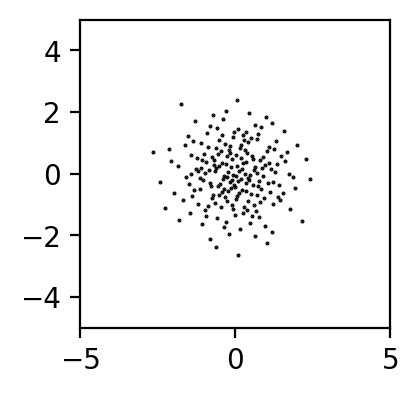

In [20]:
plt.figure(figsize=(2,2),dpi=200)
nsamples = 200
gaussPoints = qS.sampleUnitIsotropicGaussian(nsamples)
plt.scatter(gaussPoints[:,0],gaussPoints[:,1],s=.2,c='k')
plt.xlim((-5,5))
plt.ylim((-5,5))

(-5.0, 5.0)

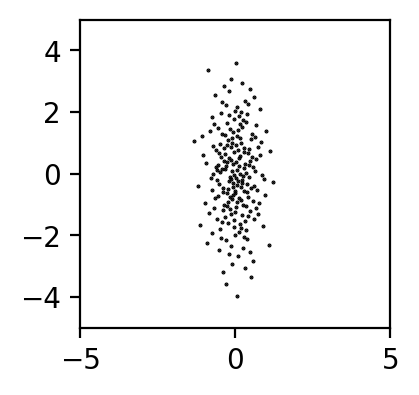

In [21]:
plt.figure(figsize=(2,2),dpi=200)
nsamples = 200
scales = np.array([.5,1.5,1])
gaussPoints = qS.sampleAnisotropicGaussian(nsamples,scales)
plt.scatter(gaussPoints[:,0],gaussPoints[:,1],s=.2,c='k')
plt.xlim((-5,5))
plt.ylim((-5,5))

In [22]:
np.std(gaussPoints,axis=0)

array([0.49128989, 1.46512114, 0.98789415])